In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import math

import numpy as np
import pandas as pd

import ROOT, uproot

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

Welcome to JupyROOT 6.18/04


In [3]:
def upsample(sample, scale):
    '''
    This function takes the sample and concatantes the same sample n times.
    '''
    if scale > 0:
        sample = np.vstack([sample]*scale)
    else:
        sample = sample
    return sample

In [4]:
input_branches = ['br_njets', 'br_nbjets', 'br_scalar_ht',
       'br_jet_pt_1', 'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_met',
       'br_met_phi', 'br_sphericity', 'br_aplanarity', 'br_fox_wolfram_1',
       'br_fox_wolfram_2', 'br_fox_wolfram_3', 'br_fox_wolfram_4']

df_signal = uproot.open("/mnt/harddisk4/scratch/ttbar_no_dtG_flat.root")["outtree"].pandas.df(input_branches)
df_dyjets = uproot.open("/mnt/harddisk4/scratch/dyjets_flat_30M.root")["outtree"].pandas.df(input_branches)
df_wjets  = uproot.open("/mnt/harddisk4/scratch/wjets_flat_60M.root")["outtree"].pandas.df(input_branches)
df_single_top  = uproot.open("/mnt/harddisk4/scratch/single_top_merged_flat.root")["outtree"].pandas.df(input_branches)
print(df_signal.keys())
#print("n_signal:", len(df_signal), "n_dyjets:", len(df_dyjets), "n_wjets:", len(df_wjets), "n_single_top", len(df_single_top))

Index(['br_njets', 'br_nbjets', 'br_scalar_ht', 'br_jet_pt_1', 'br_jet_pt_2',
       'br_jet_pt_3', 'br_jet_pt_4', 'br_met', 'br_met_phi', 'br_sphericity',
       'br_aplanarity', 'br_fox_wolfram_1', 'br_fox_wolfram_2',
       'br_fox_wolfram_3', 'br_fox_wolfram_4'],
      dtype='object')


In [5]:
x_signal = df_signal.values
y_signal = np.full(len(x_signal) , 1)
print("number of signal events:%d" % (len(x_signal)))

x_dyjets = df_dyjets.values
x_wjets  = df_wjets.values
x_single_top  = df_single_top.values

x_wjets  = upsample(x_wjets,  int((len(x_signal)/len(x_wjets))))
x_dyjets = upsample(x_dyjets, int((len(x_signal)/len(x_dyjets))))
idx_max = int(0.33*len(x_signal))
x_bkg    = np.concatenate((x_dyjets[0:idx_max], x_wjets[0:idx_max], x_single_top[0:idx_max]), axis=0)
#x_bkg    = np.concatenate((x_dyjets[0:idx_max], x_single_top[0:idx_max]), axis=0)

#x_bkg    = x_single_top[0:idx_max]
y_bkg    = np.full(len(x_bkg) , 0)
print(idx_max)

number of signal events:135342
44662


In [6]:
x_sig_train, x_sig_test, y_sig_train, y_sig_test = train_test_split(x_signal, y_signal, test_size=0.2, random_state=20)
x_bkg_train, x_bkg_test, y_bkg_train, y_bkg_test = train_test_split(x_bkg, y_bkg, test_size=0.5, random_state=20)

x_train = np.concatenate((x_sig_train, x_bkg_train), axis=0)
y_train = np.concatenate((y_sig_train, y_bkg_train), axis=0)

x_test = np.concatenate((x_sig_test, x_bkg_test), axis=0)
y_test = np.concatenate((y_sig_test, y_bkg_test), axis=0)
                                  
scaler  = preprocessing.StandardScaler().fit(np.concatenate((x_train, x_test), axis=0))
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [7]:
print("training for", len(x_train), "events;", "testing for",  len(x_test), "events")

training for 175266 events; testing for 94062 events


In [8]:
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.5816482745423232

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(x_test), y_test)

0.5816482745423232

In [10]:
x_signal_trans = scaler.transform(x_signal)

In [11]:
output_array1 = model.predict_proba(scaler.transform(x_sig_train))
output_array2 = model.predict_proba(scaler.transform(x_bkg_train))

output_array3 = model.predict_proba(scaler.transform(x_sig_test))
output_array4 = model.predict_proba(scaler.transform(x_bkg_test))

In [12]:
#print(model.evaluate(x_train, y_train))
#print(model.evaluate(x_test, y_test))
#print(model.evaluate(scaler.transform(x_signal), y_signal))
#print(model.evaluate(scaler.transform(x_bkg), y_bkg))

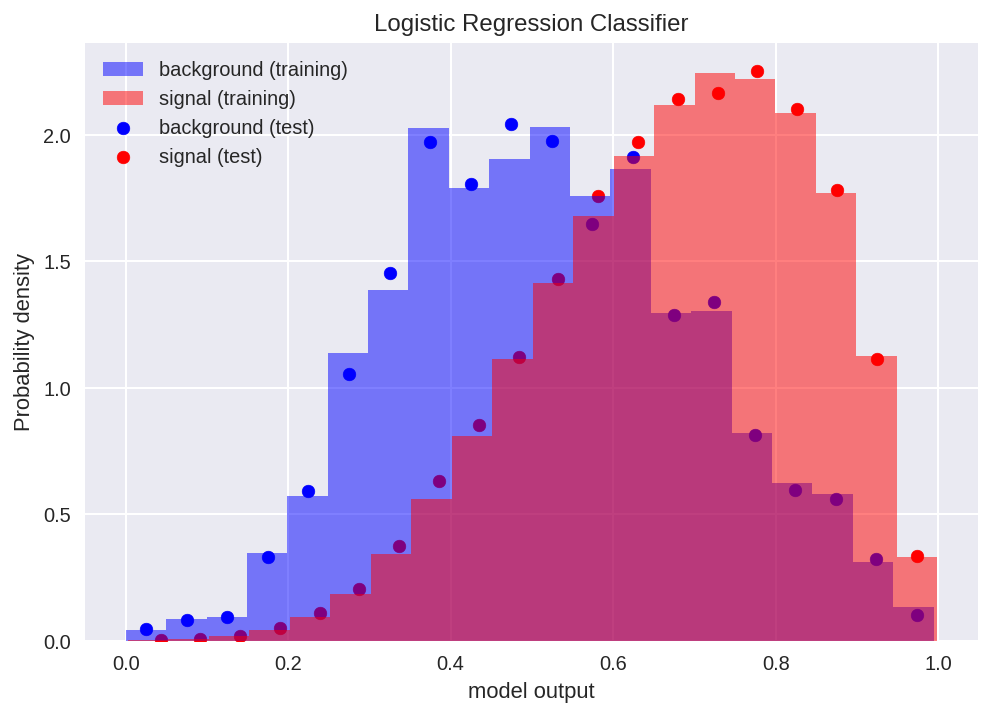

In [13]:
plt.style.use("seaborn")
fig, ax = plt.subplots()
n_bins = 20

y, bins, patches = ax.hist(output_array2[:,1], bins=n_bins, density=True, color='blue', alpha=0.5, label='background (training)')
y, bins, patches = ax.hist(output_array4[:,1], bins=n_bins, density=True, color='blue', alpha=0.0)
bin_centers = [0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)]
plt.scatter(bin_centers, y, marker='o', c='blue', s=40, alpha=1,  label='background (test)')

y, bins, patches = ax.hist(output_array1[:,1], bins=n_bins, density=True, color='red', alpha=0.5, label='signal (training)')
y, bins, patches = ax.hist(output_array3[:,1], bins=n_bins, density=True, color='red', alpha=0.0)
bin_centers = [0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)]
plt.scatter(0.5*(bins[1:] + bins[:-1]), y, marker='o', c='red', s=40, alpha=1, label='signal (test)')

ax.set_xlabel('model output')
ax.set_ylabel('Probability density')
ax.set_title("Logistic Regression Classifier")
ax.legend()
#ax.set_yscale('log')

In [14]:
def get_signal_significance(xsec_sig, xsec_bkg, lumi, output_sig, output_bkg, thresholds):
    
    significance = []
    
    for threshold in thresholds:
        
        n_sig_expected = xsec_sig * lumi
        n_bkg_expected = xsec_bkg * lumi
        
        n_sig_pred_correct = len(output_sig[output_sig>threshold])
        n_sig_pred_wrong   = len(output_sig[output_sig<threshold])
        n_bkg_pred_correct = len(output_bkg[output_bkg<threshold])
        n_bkg_pred_wrong   = len(output_bkg[output_bkg>threshold])
        
        eff_sig = n_sig_pred_correct/len(output_sig)
        eff_bkg = n_bkg_pred_correct/len(output_bkg)
        
        n_sig = n_sig_expected * eff_sig
        n_bkg = n_bkg_expected * (1-eff_bkg)
        
        n_observed = n_sig + n_bkg
        
        if n_bkg > 0:
            sig = math.sqrt(2*n_observed*math.log(1+n_sig/n_bkg)-2*n_sig)
            #sig = n_sig/math.sqrt(n_sig+n_bkg)
        else:
            sig = 0
        
        print("threshold:", "{:.3f}".format(threshold), "\n"
              "eff_sig:", "{:.3f}".format(eff_sig),
              "eff_bkg:", "{:.3f}".format(eff_bkg),
              "n_sig:", "{:.0f}".format(n_sig), 
              "n_bkg:", "{:.0f}".format(n_bkg),
              "n_observed:", "{:.0f}".format(n_observed), "\n",
              "significance:", "{:.3f}".format(sig), "\n\n")
        
        significance.append(sig)    
        
    return thresholds, np.array(significance)

In [15]:
thresholds , significance = get_signal_significance(1, 100, 50000, output_array1, 
                                                    output_array2, np.arange(0.1, 1-1e-3, 1e-2))

threshold: 0.100 
eff_sig: 1.928 eff_bkg: 0.026 n_sig: 96399 n_bkg: 4867822 n_observed: 4964221 
 significance: 43.549 


threshold: 0.110 
eff_sig: 1.912 eff_bkg: 0.032 n_sig: 95600 n_bkg: 4837744 n_observed: 4933345 
 significance: 43.323 


threshold: 0.120 
eff_sig: 1.894 eff_bkg: 0.038 n_sig: 94708 n_bkg: 4809756 n_observed: 4904465 
 significance: 43.044 


threshold: 0.130 
eff_sig: 1.877 eff_bkg: 0.045 n_sig: 93827 n_bkg: 4776171 n_observed: 4869998 
 significance: 42.793 


threshold: 0.140 
eff_sig: 1.858 eff_bkg: 0.051 n_sig: 92902 n_bkg: 4743182 n_observed: 4836084 
 significance: 42.519 


threshold: 0.150 
eff_sig: 1.839 eff_bkg: 0.058 n_sig: 91943 n_bkg: 4709223 n_observed: 4801166 
 significance: 42.232 


threshold: 0.160 
eff_sig: 1.819 eff_bkg: 0.069 n_sig: 90943 n_bkg: 4655785 n_observed: 4746728 
 significance: 42.011 


threshold: 0.170 
eff_sig: 1.798 eff_bkg: 0.076 n_sig: 89907 n_bkg: 4618318 n_observed: 4708225 
 significance: 41.701 


threshold: 0.180 
eff_si

threshold: 0.940 
eff_sig: 0.024 eff_bkg: 1.989 n_sig: 1196 n_bkg: -4946636 n_observed: -4945440 
 significance: 0.000 


threshold: 0.950 
eff_sig: 0.016 eff_bkg: 1.993 n_sig: 796 n_bkg: -4962832 n_observed: -4962036 
 significance: 0.000 


threshold: 0.960 
eff_sig: 0.009 eff_bkg: 1.994 n_sig: 459 n_bkg: -4970743 n_observed: -4970284 
 significance: 0.000 


threshold: 0.970 
eff_sig: 0.004 eff_bkg: 1.997 n_sig: 222 n_bkg: -4986193 n_observed: -4985970 
 significance: 0.000 


threshold: 0.980 
eff_sig: 0.002 eff_bkg: 1.999 n_sig: 84 n_bkg: -4994552 n_observed: -4994468 
 significance: 0.000 


threshold: 0.990 
eff_sig: 0.000 eff_bkg: 2.000 n_sig: 19 n_bkg: -4998955 n_observed: -4998936 
 significance: 0.000 




108.5403738210459


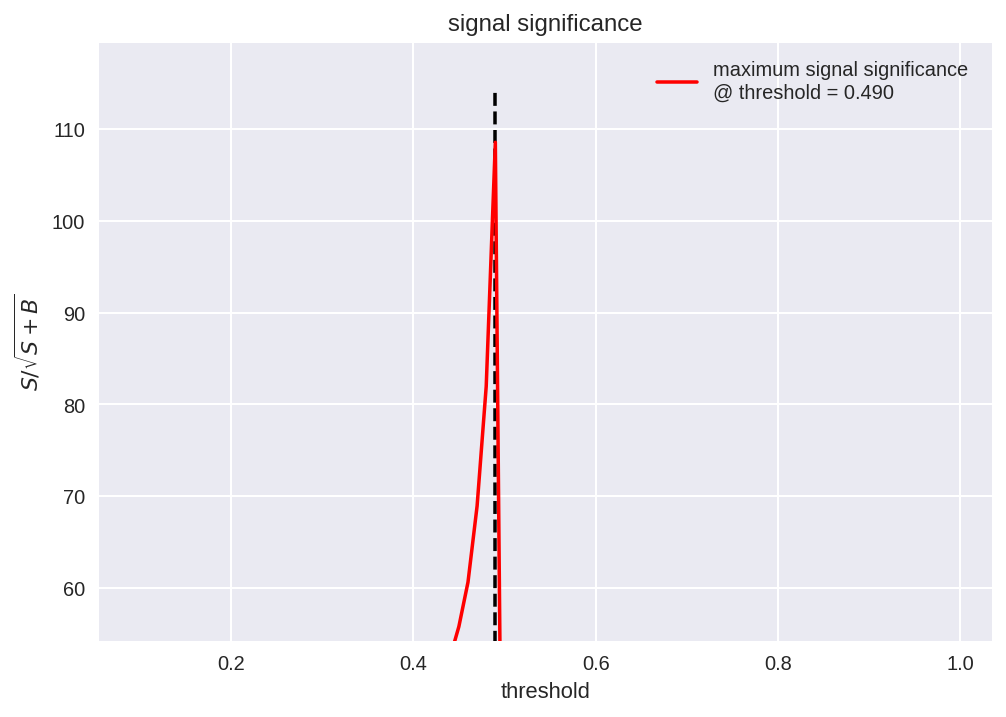

In [16]:
max_sig_threshold = thresholds[np.where(significance==max(significance))][0]
print(max(significance))
plt.figure(1)
plt.plot([max_sig_threshold, max_sig_threshold], [0, 1.05*max(significance)], 'k--')
plt.plot(thresholds, significance, label='maximum signal significance \n@ threshold = {:.3f}'.format(max_sig_threshold), color="red")
plt.xlabel('threshold')
plt.ylabel(r"$S/\sqrt{S+B}$")
plt.ylim([0.5*max(significance),1.1*max(significance)])
plt.title('signal significance')
plt.legend(loc="best")
plt.savefig("significance.pdf")

In [17]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict_proba(x_test)[:,1]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

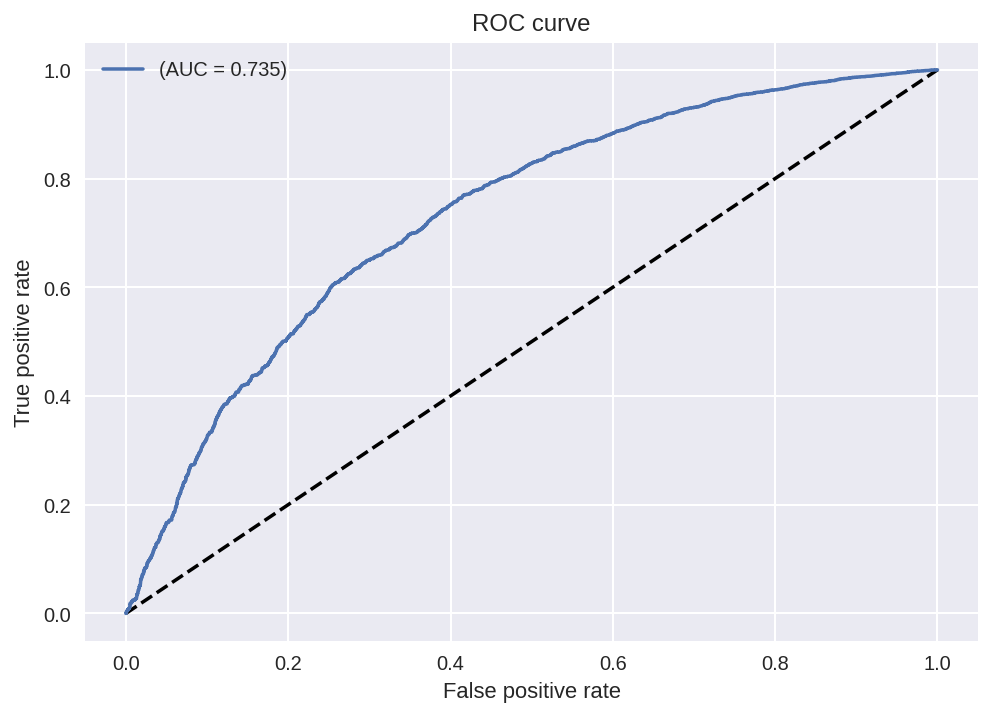

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras,tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, np.where(y_pred_keras > 0.5, 1, 0)).ravel()
accuracy    = (tp+tn)/len(y_test)
specificity = tn / (tn+fp)
sensitivity = tp / (tn+tp)
print("accuracy:", accuracy," specificity:", specificity, " sensitivity:", sensitivity);

accuracy: 0.5816482745423232  specificity: 0.47463167793650085  sensitivity: 0.4188188846849811
